In [85]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from src.generator_correct import DataGenerator
from src.blocks import Autoencoder, ConvDecoder, ConvEncoder
from torchvision import transforms
import pickle


In [86]:
with open("train_loss", "rb") as fp:
    train_loss = pickle.load(fp)
with open("val_loss", "rb") as fp:
    val_loss = pickle.load(fp)
    

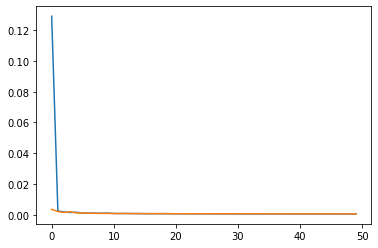

In [87]:
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")


In [103]:
path = r"data_2d"
test_df = pd.read_csv(os.path.join(path, "file_info.csv"))

test_df = test_df[test_df["Max_Value"] > 300]

scale = {'x_min': test_df["Min_Value"].min(), "x_max": test_df["Max_Value"].max()}

train_split = 0.7
val_split = 0.15
test_split = 0.15

listIDs = test_df['File_Name'].tolist()

random.seed(333)
random.shuffle(listIDs)

trainIDs = listIDs[:int(round(train_split * len(listIDs)))]
valIDs = listIDs[int(round(train_split * len(listIDs))):int(round((train_split + val_split) * len(listIDs)))]
testIDs = listIDs[int(round((train_split + val_split) * len(listIDs))):]

test_df = test_df[test_df['File_Name'].isin(testIDs)]
weights="best_model.pth"

print(len(test_df))

encoder = ConvEncoder(num_channels=64, kernel_size=5, strides=1, pooling=2)
decoder = ConvDecoder(num_channels=64, kernel_size=5, strides=2)
model = Autoencoder(encoder, decoder)

576


In [105]:
test_df

,File_Name,Min_Value,Max_Value,Mean_Value
1,img_0_slice_1.npy,-1000,1662,-619.778738
5,img_0_slice_102.npy,-1000,1630,-699.087481
9,img_0_slice_106.npy,-1000,1552,-694.988512
21,img_0_slice_117.npy,-1000,1649,-688.440663
25,img_0_slice_120.npy,-1000,1525,-688.518650
...,...,...,...,...
3823,img_9_slice_81.npy,-1000,2320,-640.063775
3832,img_9_slice_9.npy,-1000,3000,-597.544894
3833,img_9_slice_90.npy,-1000,2683,-636.928031
3836,img_9_slice_93.npy,-1000,2549,-639.671406


In [100]:
def load_model(weights_path, encoder, decoder, device='cpu'):
    """
    Function to load a pre-trained model.

    Parameters:
        weights_path (string): Path to the model weights.
        encoder (torch.nn.Module): The encoder model.
        decoder (torch.nn.Module): The decoder model.
        device (string): The device to load the model on, defaults to 'cpu'.

    Returns:
        model (torch.nn.Module): The loaded model.
    """
    model = Autoencoder(encoder, decoder)
    # Automatically map the model to the available device
    map_location = torch.device(device)
    model.load_state_dict(torch.load(weights_path, map_location=map_location))
    model.to(map_location)
    model.eval()
    return model

def preprocess_image(image_array):
    if image_array.dtype != np.float32:
        image_array = image_array.astype(np.float32)
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    image_tensor = transform(image_array)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    return image_tensor

def get_prediction(model, image_tensor, device):
    model.to(device)
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
    return output.cpu().numpy()

def plot_inference_times(csv_path):
    """
    Plots inference times from a CSV file.

    Parameters:
        csv_path (str): Path to the CSV file containing model results and inference times.
    """
    test_df = pd.read_csv(csv_path)
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(test_df['Inference_Time'])), test_df['Inference_Time'], alpha=0.5, marker='o', s=10, color='blue')
    plt.title('Inference Times for Each Image', fontsize=16)
    print(len(test_df))
    plt.xlabel('Image Index', fontsize=14)
    plt.ylabel('Inference Time (seconds)', fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Highlight the maximum and minimum points
    max_time_idx = test_df['Inference_Time'].idxmax()
    min_time_idx = test_df['Inference_Time'].idxmin()
    plt.scatter([max_time_idx], [test_df['Inference_Time'][max_time_idx]], color='red', s=50, label='Max Time')
    plt.scatter([min_time_idx], [test_df['Inference_Time'][min_time_idx]], color='green', s=50, label='Min Time')
    plt.legend()

    plt.show()


3843


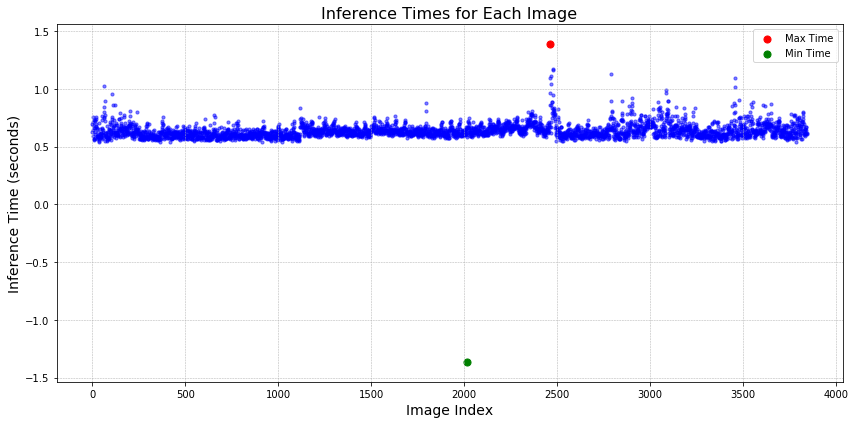

In [101]:
def main():
    path = "data_2d"
    data_df = pd.read_csv(os.path.join(path, "file_info.csv"))
    scale = {'x_min': data_df["Min_Value"].min(), "x_max": data_df["Max_Value"].max()}
    test_df = data_df[data_df["Max_Value"] > 300]  # Assuming filtering by Max_Value

    idx = np.random.randint(0, len(test_df))
    image_path = os.path.join(path, test_df.iloc[idx]["File_Name"])
    image_array = np.load(image_path)
    image_array = (image_array - scale['x_min']) / (scale['x_max'] - scale['x_min'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    weights = "best_model.pth"
    encoder = ConvEncoder(num_channels=64, kernel_size=5, strides=1, pooling=2)
    decoder = ConvDecoder(num_channels=64, kernel_size=5, strides=2)
    model = load_model(weights, encoder, decoder, device=device)

    image_tensor = preprocess_image(image_array)
    prediction = get_prediction(model, image_tensor, device)

    # Optional: Plot inference times
    csv_path = os.path.join(path, "model_results.csv")
    plot_inference_times(r"model_results.csv")

    return np.squeeze(prediction), np.squeeze(image_array)

if __name__ == "__main__":
    prediction, ground_truth = main()

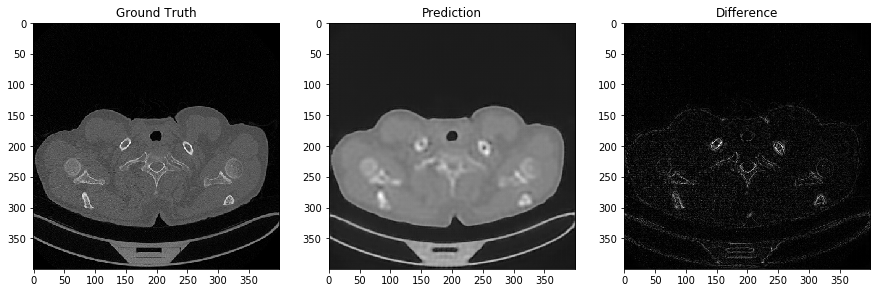

In [75]:
difference = np.abs(prediction - ground_truth)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(ground_truth, cmap='gray')
axs[0].set_title('Ground Truth')

axs[1].imshow(prediction, cmap='gray')
axs[1].set_title('Prediction')

axs[2].imshow(difference, cmap='gray')
axs[2].set_title('Difference')

plt.show()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 400, 400]           3,200
         GroupNorm-2        [-1, 128, 400, 400]             256
              ReLU-3        [-1, 128, 400, 400]               0
         MaxPool2d-4        [-1, 128, 200, 200]               0
            Conv2d-5        [-1, 128, 200, 200]         409,600
         GroupNorm-6        [-1, 128, 200, 200]             256
              ReLU-7        [-1, 128, 200, 200]               0
         MaxPool2d-8        [-1, 128, 100, 100]               0
            Conv2d-9        [-1, 128, 100, 100]         409,600
        GroupNorm-10        [-1, 128, 100, 100]             256
             ReLU-11        [-1, 128, 100, 100]               0
        MaxPool2d-12          [-1, 128, 50, 50]               0
           Conv2d-13          [-1, 128, 50, 50]         409,600
        GroupNorm-14          [-1, 128,